## 议程

- Review
- Linear regression on birth/life data
- Control Flow
- tf.data
- Optimizers, gradients
- Logistic regression on MNIST
- Loss functions

## 回顾

### 计算图

TensorFlow将计算的定义与其执行分开

阶段1：组装图表

阶段2：使用会话在图中执行操作。

### TensorBoard

In [64]:
import tensorflow as tf
x = 2
y = 3
add_op = tf.add(x, y)
mul_op = tf.multiply(x, y)
useless = tf.multiply(x, add_op)
pow_op = tf.pow(add_op, mul_op)
writer=tf.summary.FileWriter('./graphs',tf.get_default_graph())
with tf.Session() as sess:
    z = sess.run(pow_op)


### tf.constant and tf.Variable

常量值存储在图形定义中

会话分配内存来存储变量值

### tf.placeholder and feed_dict

使用字典（feed_dict）将值提供给占位符

易于使用但性能不佳

### 避免懒加载

- 分离图形的组合和执行操作
- 使用Python属性确保函数仅在第一次调用时加载

## 在TensorFlow中的线性回归

### 数据与模型概要

建模之间的线性关系：
- 因变量Y.
- 解释变量X.

世界发展指标数据集
- X: 出生率
- Y: 预期寿命

190 国家

想要：找到X和Y之间的线性关系，从X预测Y.

模型：参考: `Y_predicted = w * X + b`

均方误差: `E[(y - y_predicted)2]`

交互式代码: 

```python
data/birth_life_2010.txt
examples/03_linreg_starter.py

```

### 阶段1：组装我们的图表

#### 第一步：读数据

In [65]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
%matplotlib inline
import pandas as pd

In [66]:
# 第一种方式读取(官方)
def read_data(filename):
    '''
    读取birth_life_2010.txt 数据
    data:返回numpy数组数据
    n_samples:例子的数量
    '''
    # 去掉head
    text = open(filename, 'r').readlines()[1:]
    # 去掉每一行末尾的换行符\n，并以制表符\t进行分隔
    data = [line[:-1].split('\t') for line in text]
    # 提取出生率
    births = [float(line[1]) for line in data]
    # 提取预期寿命
    lifes = [float(line[2]) for line in data]
    # 变成[(),()]数据
    data = list(zip(births, lifes))
    # 统计数据量
    n_samples = len(data)
    # 数据转换为numpy的ndarray类型
    data = np.asarray(data, dtype=np.float32)
    return data, n_samples

In [4]:
data,n_samples=read_data('birth_life_2010.txt')

In [5]:
data

array([[ 1.822   , 74.82825 ],
       [ 3.869   , 70.81949 ],
       [ 3.911   , 72.15066 ],
       [ 5.578   , 61.999855],
       [ 1.579   , 73.92766 ],
       [ 4.229   , 67.465195],
       [ 1.15    , 81.641464],
       [ 3.86    , 72.30639 ],
       [ 3.142   , 68.484314],
       [ 3.951   , 62.44061 ],
       [ 2.16    , 80.70244 ],
       [ 2.141   , 76.30168 ],
       [ 2.002   , 64.662094],
       [ 2.504   , 68.19498 ],
       [ 3.451   , 68.76483 ],
       [ 2.635   , 74.02456 ],
       [ 1.092   , 80.775314],
       [ 2.747   , 67.064   ],
       [ 1.22    , 80.76195 ],
       [ 1.39    , 82.932686],
       [ 2.117   , 68.889656],
       [ 1.108   , 82.87805 ],
       [ 2.47    , 75.99427 ],
       [ 2.09    , 75.07688 ],
       [ 2.668   , 69.22583 ],
       [ 2.022   , 68.53214 ],
       [ 1.598   , 73.273094],
       [ 2.581   , 62.53622 ],
       [ 2.042   , 77.93202 ],
       [ 1.92    , 81.69512 ],
       [ 2.499   , 68.001   ],
       [ 1.94    , 80.402435],
       [

In [6]:
n_samples

190

In [7]:
# 第二种方式读取
def read_data(file_name):
    data = pd.read_table('birth_life_2010.txt')
    births = data['Birth rate']
    lifes = data['Life expectancy']
    data = list(zip(births,lifes))
    n_samples = len(data)
    data = np.asarray(data, dtype=np.float32)
    return data,n_samples

In [8]:
data,n_samples=read_data('birth_life_2010.txt')

In [9]:
data,n_samples

(array([[ 1.822   , 74.82825 ],
        [ 3.869   , 70.81949 ],
        [ 3.911   , 72.15066 ],
        [ 5.578   , 61.999855],
        [ 1.579   , 73.92766 ],
        [ 4.229   , 67.465195],
        [ 1.15    , 81.641464],
        [ 3.86    , 72.30639 ],
        [ 3.142   , 68.484314],
        [ 3.951   , 62.44061 ],
        [ 2.16    , 80.70244 ],
        [ 2.141   , 76.30168 ],
        [ 2.002   , 64.662094],
        [ 2.504   , 68.19498 ],
        [ 3.451   , 68.76483 ],
        [ 2.635   , 74.02456 ],
        [ 1.092   , 80.775314],
        [ 2.747   , 67.064   ],
        [ 1.22    , 80.76195 ],
        [ 1.39    , 82.932686],
        [ 2.117   , 68.889656],
        [ 1.108   , 82.87805 ],
        [ 2.47    , 75.99427 ],
        [ 2.09    , 75.07688 ],
        [ 2.668   , 69.22583 ],
        [ 2.022   , 68.53214 ],
        [ 1.598   , 73.273094],
        [ 2.581   , 62.53622 ],
        [ 2.042   , 77.93202 ],
        [ 1.92    , 81.69512 ],
        [ 2.499   , 68.001   ],
        

#### 第2步：为输入和标签创建占位符

In [10]:
# tf.placeholder(dtype, shape=None, name=None)
X,Y=None,None
X = tf.placeholder(dtype=tf.float32)
Y = tf.placeholder(dtype=tf.float32)

#### 第3步：创建权重和偏置

In [11]:
# tf.get_variable(name,shape=None,dtype=None,initializer=None,)
# w,b,X,Y都是标量，shape=()可设置为shape=[]
w,b = None,None
w = tf.get_variable(name='weght',shape=(),initializer=tf.zeros_initializer())
b = tf.get_variable(name='bias',shape=(),initializer=tf.zeros_initializer())

#### 第4步：预测

In [12]:
Y_predicted = None
Y_predicted = w * X + b

#### 第5步：指定损失函数

In [13]:
loss = None
loss = tf.square(Y - Y_predicted, name='loss')

#### 第6步：创建优化器

In [14]:
opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)
optimizer = opt.minimize(loss)

In [15]:
import time
start = time.time()

### 阶段2：训练我们的模型

#### 第7步：初始化及TensorBoard

In [16]:
with tf.Session() as sess:
    # 初始化变量
    sess.run(tf.global_variables_initializer())
    # tensorboard
    writer = tf.summary.FileWriter('./graphs/linear_reg',sess.graph)
    ...

#### 第8步：训练模型100个epochs

In [17]:
with tf.Session() as sess:
    # 初始化变量
    sess.run(tf.global_variables_initializer())
    # tensorboard
    writer = tf.summary.FileWriter('./graphs/linear_reg',sess.graph)
    # trian the model for 100 epoch
    for i in range(100):
        # 初始化每一次的loss
        total_loss=0
        # 每一次，一批批训练
        for x,y in data:
            # 需要运行优化函数optimizer与loss， Tensorflow 会自动更新weight 和bias 两个变量
            _,loss_ = sess.run([optimizer,loss],feed_dict={X:x,Y:y})
            total_loss += loss_
        print('Epoch {0}:{1}'.format(i,total_loss/n_samples))
    writer.close()

Epoch 0:1661.8637834631543
Epoch 1:956.3224148609137
Epoch 2:844.6737023980994
Epoch 3:750.7312486011339
Epoch 4:667.6598341012079
Epoch 5:594.1417715627896
Epoch 6:529.07878103068
Epoch 7:471.5004191489204
Epoch 8:420.5458626462441
Epoch 9:375.45530721966765
Epoch 10:335.5543025185697
Epoch 11:300.24629857978107
Epoch 12:269.00376475843336
Epoch 13:241.35957466852116
Epoch 14:216.90039135300015
Epoch 15:195.25972298129324
Epoch 16:176.1137693605349
Epoch 17:159.17551693441837
Epoch 18:144.1907111125557
Epoch 19:130.93503488078713
Epoch 20:119.20935661137888
Epoch 21:108.8379309807855
Epoch 22:99.66466760624593
Epoch 23:91.55177013029001
Epoch 24:84.37664046781751
Epoch 25:78.03217824997724
Epoch 26:72.42182927812989
Epoch 27:67.46136239485718
Epoch 28:63.07566952367442
Epoch 29:59.19874146522856
Epoch 30:55.77168446383194
Epoch 31:52.74269822355127
Epoch 32:50.065632780875376
Epoch 33:47.70006421631674
Epoch 34:45.61017902122909
Epoch 35:43.76379750625255
Epoch 36:42.13259221098116
Ep

#### 第9步：输出w和b的值

In [18]:
with tf.Session() as sess:
    # 初始化变量
    sess.run(tf.global_variables_initializer())
    # tensorboard
    writer = tf.summary.FileWriter('./graphs/linear_reg',sess.graph)
    # trian the model for 100 epoch
    for i in range(100):
        # 初始化每一次的loss
        total_loss=0
        # 每一次，一批批训练
        for x,y in data:
            # 需要运行优化函数optimizer与loss， Tensorflow 会自动更新weight 和bias 两个变量
            _,loss_ = sess.run([optimizer,loss],feed_dict={X:x,Y:y})
            total_loss += loss_
        print('Epoch {0}:{1}'.format(i,total_loss/n_samples))
    writer.close()
    # 第9步：输出w和b的值
    w_out,b_out = None,None
    w_out, b_out = sess.run([w, b])

Epoch 0:1661.8637834631543
Epoch 1:956.3224148609137
Epoch 2:844.6737023980994
Epoch 3:750.7312486011339
Epoch 4:667.6598341012079
Epoch 5:594.1417715627896
Epoch 6:529.07878103068
Epoch 7:471.5004191489204
Epoch 8:420.5458626462441
Epoch 9:375.45530721966765
Epoch 10:335.5543025185697
Epoch 11:300.24629857978107
Epoch 12:269.00376475843336
Epoch 13:241.35957466852116
Epoch 14:216.90039135300015
Epoch 15:195.25972298129324
Epoch 16:176.1137693605349
Epoch 17:159.17551693441837
Epoch 18:144.1907111125557
Epoch 19:130.93503488078713
Epoch 20:119.20935661137888
Epoch 21:108.8379309807855
Epoch 22:99.66466760624593
Epoch 23:91.55177013029001
Epoch 24:84.37664046781751
Epoch 25:78.03217824997724
Epoch 26:72.42182927812989
Epoch 27:67.46136239485718
Epoch 28:63.07566952367442
Epoch 29:59.19874146522856
Epoch 30:55.77168446383194
Epoch 31:52.74269822355127
Epoch 32:50.065632780875376
Epoch 33:47.70006421631674
Epoch 34:45.61017902122909
Epoch 35:43.76379750625255
Epoch 36:42.13259221098116
Ep

#### 第10步：输出耗时

In [19]:
print('Took: %f seconds' %(time.time() - start))
print('last value of loss, w, b: {0}, {1}, {2}'.format(total_loss/n_samples, w_out, b_out))

Took: 25.186522 seconds
last value of loss, w, b: 30.03552558278714, -6.07021427154541, 84.92951202392578


#### 第11步：可视化

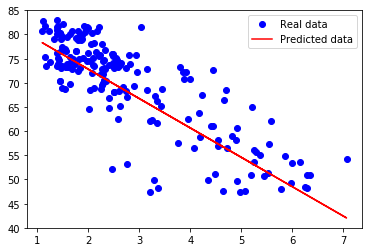

In [20]:
import matplotlib.pyplot as plt
plt.plot(data[:,0], data[:,1], 'bo', label='Real data')
plt.plot(data[:,0], data[:,0] * w_out + b_out, 'r', label='Predicted data')
plt.legend()

## Huber loss

Huber loss是为了增强平方误差损失函数（squared loss function）对噪声（或叫离群点，outliers）的鲁棒性提出的。

对异常值的鲁棒性，如果预测值和实际值之间的差异很小，则将其平方;如果它很大，取其绝对值。

定义：

\begin{split}
L_\delta(a)=\left \{
\begin{array}{ll}
\frac12a^2,&\textrm{for } |a|\leq\delta,\\
\delta\cdot(|a|-\frac12\delta),&\textrm{otherwise.}
\end{array}
\right.
\end{split}

参数a通常表示residuals，也即(y−y^)或者写作(y−f(x))，当a=y−f(x)时，上述形式可以拓展为： 

\begin{split}
L_\delta(y, f(x))=\left\{
\begin{array}{ll}
\frac12(y-f(x))^2,&\textrm{for }|y-f(x)|\leq\delta\\
\delta\cdot(|y-f(x)|-\frac12\delta),&\textrm{otherwise.}
\end{array}
\right.
\end{split}

### 控制流程

在TensorFlow中，tf.cond()类似于c语言中的if...else...，用来控制数据流向，但是仅仅类似而已，其中差别还是挺大的。

格式：`tf.cond(pred, fn1, fn2, name=None)`

In [23]:
def huber_loss(label, prediction, delta=14.0):
    residual = tf.abs(label - prediction)
    def f1(): return 0.5*tf.square(residual)
    def f2(): return delta*residual-0.5*tf.square(delta)
    return tf.cond(residual < delta, f1,f2)
# cond函数分为true和false两种情况。在许多情况下，使用函数tf.case。

## tf.data

在上面的代码我曾经使用过数据placeholder。但是占位符是一种古老的方式，关于这种方法有各种各样的意见。看来有利于的是，它是一个点，缺点在于它可以很容易地处理数据外的TF较慢处理应被视为一个单独的线程中的数据，和数据瓶颈。因此，这个问题得以解决tf.data。

如何使用tf.data?

```python
tf.data.Dataset.from_tensor_slices((feature, labels))
tf.data.Dataset.from_generator(gen, output_types, output_shapes)
```


`feature`和`labels`必须是Tensor数据类型。但是，由于张量数据类型与numpy数据类型相同，因此可以包含numpy数据类型。

In [27]:
# 换句话说，如果您从上面的模型中读取数据为tf.data，您可以写：
data,n_samples=read_data('birth_life_2010.txt')
dataset = tf.data.Dataset.from_tensor_slices((data[:,0], data[:,1]))

In [33]:
dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.float32, tf.float32)>

In [29]:
print(dataset.output_types) # >> (tf.float32, tf.float32)
print(dataset.output_shapes) # >> (TensorShape([]), TensorShape([]))

(tf.float32, tf.float32)
(TensorShape([]), TensorShape([]))


tf.data.Dataset有几种方法，你可以直接读取数据文件Tensorflow文件格式分析器。

`tf.data.TextLineDataset(filenames)` 将文件的每一行读作一个数据。它主要用于读取csv文件和机器翻译领域。

`tf.data.FixedLengthRecordData(filenames)`它主要用于固定长度数据。数据作为一个数据被接收预定长度。经常使用的地方也经常用于由固定长度组成的数据中。例如，它用于读取诸如CIFAR数据或ImageNet数据之类的内容。

`tf.data.TFRecordDataset(filenames)`用于tfrecord格式的数据。

我看到了如何读取数据。现在让我们看一下使用数据。在现有代码中，我们for通过语句逐个使用数据的值。`tf.data.Iterator`使得逐个使用数据变得更加容易。

### tf.data.Iterator

`iterator = dataset.make_one_shot_iterator()`

通过数据集只迭代一次。无需初始化。

`iterator = dataset.make_initializable_iterator()`

根据需要迭代数据集。需要初始化每个epoch。

In [37]:
iterator = dataset.make_one_shot_iterator()
X, Y = iterator.get_next()

In [40]:
with tf.Session() as sess:
    print(sess.run([X, Y]))		# >> [1.822, 74.82825]
    print(sess.run([X, Y]))		# >> [3.869, 70.81949]
    print(sess.run([X, Y]))		# >> [3.911, 72.15066]

[1.822, 74.82825]
[3.869, 70.81949]
[3.911, 72.15066]


### 处理TensorFlow中的数据

```python
dataset = dataset.shuffle(1000)
dataset = dataset.repeat(100)
dataset = dataset.batch(128)
dataset = dataset.map(lambda x: tf.one_hot(x, 10)) # convert each elem of dataset to one_hot vector
```

### 我们应该使用tf.data?

对于原型设计，feed dict可以更快更容易编写（pythonic）

当您有复杂的预处理或多个数据源时，tf.data很难使用

NLP数据通常只是一个整数序列。在这种情况下，将数据传输到GPU非常快，因此tf.data的加速并不是那么大

## 优化

使用优化器非常简单。然而只有几行代码可以方便地使用（差分，更新）复杂的配置的优化器。

```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
_, l = sess.run([optimizer, loss], feed_dict={X: x, Y:y})
```
会话查看损失所依赖的所有可训练变量并更新它们

`tf.Variable(initial_value=None, trainable=True,...)`

优化程序会自动计算和更新衍生值。因此，它适用于所有相关变量。在某些情况下，可能存在不应更新的变量。在这种变量的情况下，`trainable=False`通过仅将其指定为选项，可以很容易地将其设置为不训练

除了上面使用的GD opmizer之外，还提供了各种其他优化器作为张量流函数。以下是优化器列表。

- tf.train.Optimizer
- tf.train.GradientDescentOptimizer
- tf.train.AdadeltaOptimizer
- tf.train.AdagradOptimizer
- tf.train.AdagradDAOptimizer
- tf.train.MomentumOptimizer
- tf.train.AdamOptimizer
- tf.train.FtrlOptimizer
- tf.train.ProximalGradientDescentOptimizer
- tf.train.ProximalAdagradOptimizer
- tf.train.RMSPropOptimizer